# Day 4: Supply I - Enhancing the model

We will continue our modeling exercise by adding investment to the model.

This will allow us to consider the policy impacts of alternative energy transition policies. As a start, *we will include a carbon tax* in the simulations.

The data and code are based on the paper "The Efficiency and Sectoral Distributional Implications of Large-Scale Renewable Policies," by Mar Reguant.

We first load relevant libraries, same as last session.

In [17]:
using Pkg
Pkg.add(["DataFrames", "CSV", "JuMP", "Ipopt", "Cbc", "HiGHS","Plots", "Printf"])

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [18]:
using DataFrames
using CSV
using JuMP
using Ipopt, Cbc, HiGHS
using Plots
using StatsBase
using Printf

Remember to set your path correctly:

In [19]:
dirpath = "/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2025/day4/practicum/"

"/Users/marreguant/Dropbox/TEACHING/BSE/Electricity2025/day4/practicum/"

## Building the model

We load the same data as last week, and also clean it up to simplify it further and create the demand and import curves.

In [20]:
dfclust = CSV.read(string(dirpath,"data_jaere_clustered.csv"), DataFrame);

# Re-scaling (we multiply by 8.76 to make it into a full year of hours (divided by 1000))
dfclust.weights = 8.76 * dfclust.weights / sum(dfclust.weights);

# Here only one demand type to make it easier
dfclust.demand = dfclust.q_residential + dfclust.q_commercial + dfclust.q_industrial;

# Calibrate demand based on elasticities (using 0.1 here as only one final demand)
elas = [.1, .2, .5, .3];
dfclust.b = elas[1] * dfclust.demand ./ dfclust.price;  # slope
dfclust.b .= mean(dfclust.b);  # average over clusters
dfclust.a = dfclust.demand + dfclust.b .* dfclust.price;  # intercept

# Calibrate imports (using elas 0.3)
dfclust.bm = elas[4] * dfclust.imports ./ dfclust.price;  # slope
dfclust.bm .= mean(dfclust.bm);  # average over clusters
dfclust.am = dfclust.imports - dfclust.bm .* dfclust.price;  # intercept

In [21]:
dfclust

Row,price,imports,q_commercial,q_industrial,q_residential,wind_cap,solar_cap,hydronuc,weights,demand,b,a,bm,am
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,52.6844,9.32972,19.4425,3.83276,13.9897,0.31759,0.650792,9.46003,0.0514606,37.265,0.0923286,42.1293,0.0771438,5.26545
2,34.654,8.09594,11.0544,3.24581,13.4298,0.256715,0.00651777,4.0713,0.148529,27.73,0.0923286,30.9296,0.0771438,5.4226
3,32.3196,8.41267,14.0695,3.43187,9.80489,0.136232,0.0571869,6.70831,0.0669996,27.3062,0.0923286,30.2902,0.0771438,5.91941
4,34.4721,6.68697,15.0617,6.14058,8.93031,0.259152,0.718544,3.68863,0.107159,30.1326,0.0923286,33.3153,0.0771438,4.02766
5,37.2787,6.17066,9.65466,3.29223,9.21121,0.449678,0.0259009,2.83917,0.170526,22.1581,0.0923286,25.6,0.0771438,3.29484
6,26.7867,7.03938,13.6814,5.02118,7.77317,0.168569,0.432051,2.98317,0.109177,26.4758,0.0923286,28.949,0.0771438,4.97295
7,32.5801,8.27651,14.7801,5.37046,5.95472,0.48007,0.0181763,3.56338,0.0609454,26.1053,0.0923286,29.1134,0.0771438,5.76316
8,67.0488,7.45997,11.647,4.13495,12.0611,0.226027,0.00981431,3.11872,0.0653852,27.843,0.0923286,34.0335,0.0771438,2.28757
9,40.0577,9.16049,13.6316,3.62875,18.3038,0.489334,0.0277282,5.48247,0.0817315,35.5642,0.0923286,39.2627,0.0771438,6.07028


The technology file now includes the fixed cost of building new power plants (technologies 3-5). Note that we added an additional row for new natural gas plants.

We will use an annualization factor to pro-rate the importance of fixed costs for one year.

In [ ]:
tech = CSV.read(string(dirpath,"data_technology.csv"), DataFrame);
afactor = (1 - (1 / (1.05^20.0))) / 0.05; #20 year amortization horizon with 5% discount rate
tech.F = tech.F ./afactor;
tech

Row,techname,heatrate,heatrate2,F,capLB,capUB,new,renewable,solar,thermal,e,e2,c,c2
,String15,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,Hydro/Nuclear,10.0,0.0,0.0,1.0,1.0,0,0,0,0,0.0,0.0,10.0,0.0
2,Existing 1,6.67199,0.0929123,0.0,11.5,11.5,0,0,0,1,0.360184,0.0048861,23.352,0.325193
3,Existing 2,9.79412,0.286247,0.0,14.5,14.5,0,0,0,1,0.546134,0.0110777,34.2794,1.00187
4,Existing 3,13.8181,20.5352,0.0,0.578,0.578,0,0,0,1,0.816768,0.234476,48.3634,71.8731
5,New Gas,6.6,0.0,78.4773,0.0,100.0,1,0,0,1,0.35,0.0,23.352,0.325193
6,Wind,0.0,0.0,100.303,0.0,100.0,1,1,0,0,0.0,0.0,0.0,0.0
7,Solar,0.0,0.0,100.303,0.0,100.0,1,1,1,0,0.0,0.0,0.0,0.0


In [23]:
for i = 2:5
        tech.c[i] = tech.heatrate[i] * 3.5;
        tech.c2[i] = tech.heatrate2[i] * 3.5;
end

In [ ]:
tech

Row,techname,heatrate,heatrate2,F,capLB,capUB,new,renewable,solar,thermal,e,e2,c,c2
,String15,Float64,Float64,Float64,Float64,Float64,Int64,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,Hydro/Nuclear,10.0,0.0,0.0,1.0,1.0,0,0,0,0,0.0,0.0,10.0,0.0
2,Existing 1,6.67199,0.0929123,0.0,11.5,11.5,0,0,0,1,0.360184,0.0048861,23.352,0.325193
3,Existing 2,9.79412,0.286247,0.0,14.5,14.5,0,0,0,1,0.546134,0.0110777,34.2794,1.00187
4,Existing 3,13.8181,20.5352,0.0,0.578,0.578,0,0,0,1,0.816768,0.234476,48.3634,71.8731
5,New Gas,6.6,0.0,78.4773,0.0,100.0,1,0,0,1,0.35,0.0,23.1,0.0
6,Wind,0.0,0.0,100.303,0.0,100.0,1,1,0,0,0.0,0.0,0.0,0.0
7,Solar,0.0,0.0,100.303,0.0,100.0,1,1,1,0,0.0,0.0,0.0,0.0


## 1) Adding investment solving "by hand"

This will update the code to compute profits. Here we will focus on natural gas investment but one can add any profit. 

Other than that, we will be solving the model as if investment is already chosen, those not adding any additional complication to the social planner problem.

In [25]:
## Clear market based on cost minimization
function clear_market_profit(data::DataFrame, tech::DataFrame; 
    wind_gw = 0.0, solar_gw = 0.0, gas_gw = 0.0, ng_price = 3.5)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            Ipopt.Optimizer, 
                "print_level"=>0)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods
    
    for i = 2:5
        tech.c[i] = tech.heatrate[i] * ng_price;
        tech.c2[i] = tech.heatrate2[i] * ng_price;
    end
        
    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, costs[1:T]);
    @variable(model, gross_surplus[1:T]);

    # Maximize welfare including imports costs
    @NLobjective(model, Max, sum(data.weights[t] * 
                (gross_surplus[t] - costs[t]) for t=1:T));

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Define surplus
    @constraint(model, [t=1:T], gross_surplus[t]==
                (data.a[t] - demand[t]) * demand[t] / data.b[t] 
            + demand[t]^2/(2*data.b[t]));

    # Define cost
    @constraint(model, [t=1:T], costs[t] ==
                    sum(tech.c[i] * quantity[t,i]
                    + tech.c2[i] * quantity[t,i]^2/2 for i=1:I)
        + (imports[t] - data.am[t])^2/(2 * data.bm[t]));
    
    # Constraints on output
    @constraint(model, [t=1:T], 
      quantity[t,1] <= data.hydronuc[t]);
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= gas_gw);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,7] <= solar_gw * data.solar_cap[t]);

    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="LOCALLY_SOLVED")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t]/sum(data.weights) for t=1:T);
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = sum(data.weights[t] * (sum(tech.c[i] * q[t,i] 
                + tech.c2[i] * q[t,i]^2 / 2 for i=1:I) 
                + (imp[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T);
        surplus = sum(data.weights[t] * (JuMP.value.(gross_surplus[t]) - JuMP.value.(costs[t])) for t=1:T) - tech.F[5]*gas_gw  - tech.F[6]*(wind_gw) - tech.F[7]*JuMP.value.(solar_gw);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "profit_gas" => sum(data.weights[t] * (p[t] - tech.c[5]) * q[t,5]/gas_gw for t=1:T) - tech.F[5],
            "profit_wind" => sum(data.weights[t] * (p[t] - tech.c[6]) * data.wind_cap[t] for t=1:T) - tech.F[6],
            "profit_solar" => sum(data.weights[t] * (p[t] - tech.c[7]) * data.solar_cap[t] for t=1:T) - tech.F[7],
            "surplus" => surplus);
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_profit (generic function with 1 method)

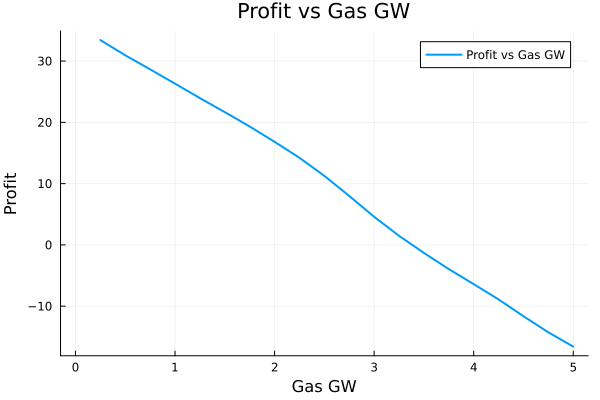

In [26]:
gas_grid = 0.0:0.25:5.0; # in GW (F is in GW)
profits = [clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=0.0, gas_gw=g)["profit_gas"] for g in gas_grid];
plot(gas_grid, profits, xlabel="Gas GW", ylabel="Profit", label="Profit vs Gas GW", lw=2, legend=:topright, title="Profit vs Gas GW")

In [27]:
clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=16.0, gas_gw=0.01, ng_price=4.5)

Dict{String, Any} with 11 entries:
  "avg_price"    => 36.985
  "profit_wind"  => 0.531596
  "price"        => [47.6082, 34.799, 34.0785, 46.6886, 32.8245, 40.0404, 32.76…
  "profit_solar" => -33.1726
  "status"       => "LOCALLY_SOLVED"
  "quantity"     => [9.46003 11.5 … 5.08144 9.05826e-9; 4.0713 11.4207 … 4.1074…
  "imports"      => [8.93812, 8.10713, 8.54836, 7.6294, 5.82705, 8.06182, 8.290…
  "demand"       => [37.7337, 27.7166, 27.1438, 29.0046, 22.5693, 25.2521, 26.0…
  "profit_gas"   => -10.5709
  "surplus"      => 37910.9
  "cost"         => 3601.0

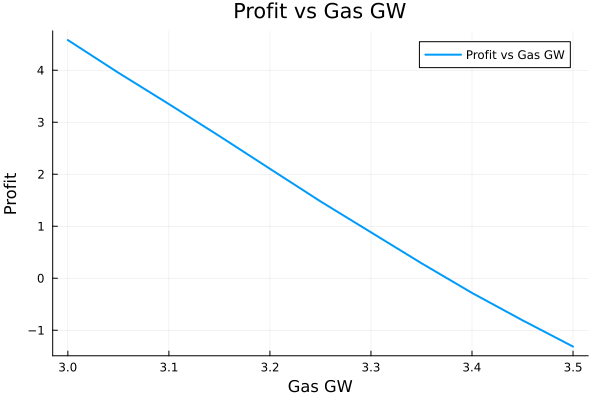

In [28]:
gas_grid = 3.0:0.05:3.5;
profits = [clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=0.0, gas_gw=g)["profit_gas"] for g in gas_grid];
plot(gas_grid, profits, xlabel="Gas GW", ylabel="Profit", label="Profit vs Gas GW", lw=2, legend=:topright, title="Profit vs Gas GW")

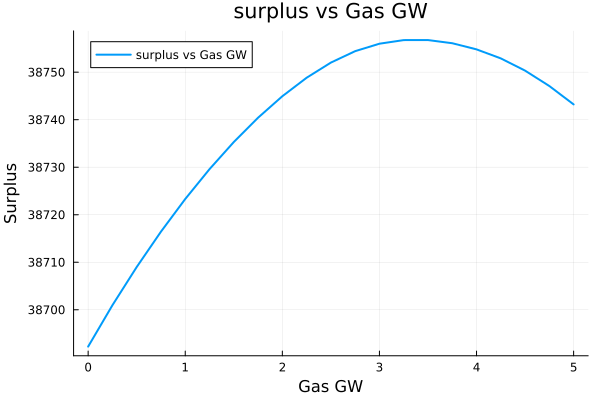

In [29]:
gas_grid = 0.0:0.25:5.0;
surplus = [clear_market_profit(dfclust, tech, solar_gw=0.0, wind_gw=0.0, gas_gw=g)["surplus"] for g in gas_grid];
plot(gas_grid, surplus, xlabel="Gas GW", ylabel="Surplus", label="surplus vs Gas GW", lw=2, legend=:topleft, title="surplus vs Gas GW")

## 2) Adding investment with social planner

We are now ready to clear the market. We will **maximize welfare** using a non-linear solver.

$$ \max \ CS - Costs - Fixed Costs \\

\text{s.t.} \ \text{operational constraints, market clearing}. $$

Notice that we added the fixed costs to the problem, as we will be solving for the optimal level of wind and solar investment.

In [30]:
## Clear market based on cost minimization
function clear_market_invest(data::DataFrame, tech::DataFrame; ng_price = 3.5, tax=50.0)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            Ipopt.Optimizer, 
                "print_level"=>0)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods

    for i = 2:5
        tech.c[i] = tech.heatrate[i] * ng_price;
        tech.c2[i] = tech.heatrate2[i] * ng_price;
    end
    
    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, costs[1:T]);
    @variable(model, gross_surplus[1:T]);
    @variable(model, gas_gw >= 0.0);
    @variable(model, wind_gw >= 0.0);
    @variable(model, solar_gw >= 0.0);

    # Maximize welfare including imports costs
    @objective(model, Max, sum(data.weights[t] * 
                (gross_surplus[t] - costs[t]) for t=1:T)
             - tech.F[5]*gas_gw  - tech.F[6]*wind_gw - tech.F[7]*solar_gw);

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Define surplus
    @constraint(model, [t=1:T], gross_surplus[t]==
                (data.a[t] - demand[t]) * demand[t] / data.b[t] 
            + demand[t]^2/(2*data.b[t]));

    # Define cost
    @constraint(model, [t=1:T], costs[t] ==
                    sum(tech.c[i] * quantity[t,i]
                    + tech.c2[i] * quantity[t,i]^2/2 + tax * tech.e[i] * quantity[t,i]  for i=1:I)
        + (imports[t] - data.am[t])^2/(2 * data.bm[t]))
        # 
        # - subsidy * tech.renewable[i] * quantity[t,i] 
    # Constraints on output
    @constraint(model, [t=1:T], 
        quantity[t,1] <= data.hydronuc[t]);
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= gas_gw);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= wind_gw * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,7] <= solar_gw * data.solar_cap[t]);


    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="LOCALLY_SOLVED")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t]/sum(data.weights) for t=1:T);
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = JuMP.value.(costs);
        profit = sum(data.weights[t] * (p[t] * q[t,5] - tech.c[5] * q[t,5]) for t=1:T) - tech.F[5]*JuMP.value.(gas_gw);
        surplus = sum(data.weights[t] * (JuMP.value.(gross_surplus[t]) - JuMP.value.(costs[t])) for t=1:T) - 
            tech.F[5]*JuMP.value.(gas_gw)  - tech.F[6]*JuMP.value.(wind_gw) - tech.F[7]*JuMP.value.(solar_gw);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "gas_gw" => JuMP.value.(gas_gw),
            "wind_gw" => JuMP.value.(wind_gw),
            "solar_gw" => JuMP.value.(solar_gw),
            "profit_gas" => profit,
            "surplus" => surplus);
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_invest (generic function with 1 method)

In [31]:
results = clear_market_invest(dfclust, tech, ng_price=3.5, tax=50.0)

Dict{String, Any} with 12 entries:
  "avg_price"  => 39.8138
  "price"      => [44.9788, 43.6507, 43.5, 44.9135, 41.4226, 44.2548, 39.542, 6…
  "gas_gw"     => -9.96479e-9
  "status"     => "LOCALLY_SOLVED"
  "quantity"   => [9.46003 11.1244 … 8.65675 3.13396e-9; 4.0713 7.04061 … 6.997…
  "solar_gw"   => -9.96368e-9
  "imports"    => [8.73528, 8.78998, 9.27517, 7.49245, 6.49034, 8.38693, 8.8135…
  "demand"     => [37.9764, 26.8994, 26.2739, 29.1685, 21.7755, 24.863, 25.4625…
  "profit_gas" => 5.38046e-7
  "surplus"    => 37221.5
  "cost"       => [652.874, 413.475, 419.141, 585.908, 102.39, 486.283, 95.9435…
  "wind_gw"    => 27.2577

## 3) Adding investment with integer variables

We modify our mixed integer code with an additional "dummy" variable that allows for a corner solution at zero investment. If at zero investment firms make no money, then the zero profit condition is negative. Otherwise, the zero profit condition must be zero.

In [ ]:
## Clear market based on first-order conditions
function clear_market_foc(data::DataFrame, tech::DataFrame; ng_price = 3.5, tax=50.0, theta=0.0)

    # We declare a model
    model = Model(
        optimizer_with_attributes(
            HiGHS.Optimizer)
        );

    # Set useful indexes
    I = nrow(tech);  # number of techs
    T = nrow(data);  # number of periods
    M = 1e4;

    for i = 2:5
        tech.c[i] = tech.heatrate[i] * ng_price;
        tech.c2[i] = tech.heatrate2[i] * ng_price;
    end

    # Variables to solve for
    @variable(model, price[1:T]);
    @variable(model, demand[1:T]);
    @variable(model, imports[1:T]);
    @variable(model, quantity[1:T, 1:I] >= 0);
    @variable(model, shadow[1:T, 1:I] >= 0);  # price wedge if at capacity
    @variable(model, 0 <= K[5:I] <= 150.0);  # new capacity
    @variable(model, profit[5:I]); # tech annual profits, at most zero in equilibrium
    @variable(model, u1[1:T, 1:I], Bin);  # if tech used
    @variable(model, u2[1:T, 1:I], Bin);  # if tech at max
    @variable(model, u3[5:I], Bin);  # if tech is built


    @objective(model, Min, sum(price[t] * data.weights[t] for t=1:T));

    # Market clearing
    @constraint(model, [t=1:T], 
        demand[t] == data.a[t] - data.b[t] * price[t]);
    @constraint(model, [t=1:T], 
        imports[t] == data.am[t] + data.bm[t] * price[t]);
    @constraint(model, [t=1:T], 
        demand[t] == sum(quantity[t,i] for i=1:I) + imports[t]);

    # Capacity constraints
    @constraint(model, [t=1:T], 
        quantity[t,1] <= u1[t,1] * data.hydronuc[t]); #we can only use the technology if u1 = 1
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] <= u1[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T, i=5:I], 
        quantity[t,i] <= u1[t,i] * 100.0);
    @constraint(model, [t=1:T], 
        quantity[t,5] <= K[5]);
    @constraint(model, [t=1:T], 
        quantity[t,6] <= K[6] * data.wind_cap[t]);
    @constraint(model, [t=1:T], 
        quantity[t,7] <= K[7] * data.solar_cap[t]);

    @constraint(model, [t=1:T], 
        quantity[t,1] >= u2[t,1] * data.hydronuc[t]); #if u2 = u1 = 1, hydronuc <= q <= hydronuc
    @constraint(model, [t=1:T,i=2:4], 
        quantity[t,i] >= u2[t,i] * tech[i,"capUB"]);
    @constraint(model, [t=1:T], 
        quantity[t,5] >= K[5] - M * (1.0-u2[t,5]));
    @constraint(model, [t=1:T], 
        quantity[t,6] >= K[6] * data.wind_cap[t] - M * (1.0-u2[t,6]));
    @constraint(model, [t=1:T], 
        quantity[t,7] >= K[7] * data.solar_cap[t] - M * (1.0-u2[t,7]));

    @constraint(model, [t=1:T,i=1:I], u1[t,i] >= u2[t,i]);

    # Constraints on optimality 
    @constraint(model, [t=1:T,i=1:4],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - theta * quantity[t,i]/(data.b[t]+data.bm[t]) - tax * tech.e[i] - shadow[t,i] 
        >= -M * (1.0-u1[t,i]));
    @constraint(model, [t=1:T,i=1:4],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - theta * quantity[t,i]/(data.b[t]+data.bm[t]) - tax * tech.e[i] - shadow[t,i] 
        <= 0.0);
    # New entrants don't exercise market power
    @constraint(model, [t=1:T,i=5:7],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - tax * tech.e[i] - shadow[t,i] 
        >= -M * (1.0-u1[t,i]));
    @constraint(model, [t=1:T,i=5:7],
        price[t] - tech.c[i] - tech.c2[i]*quantity[t,i] - tax * tech.e[i] - shadow[t,i] 
        <= 0.0);
    @constraint(model, [t=1:T,i=1:I], shadow[t,i] <= M*u2[t,i]);

    # Definition of profit
    @constraint(model, profit[5] == 
                        sum(data.weights[t]*shadow[t,5] for t=1:T) - tech.F[5]);
    @constraint(model, profit[6] == 
                        sum(data.weights[t]*shadow[t,6]*data.wind_cap[t] for t=1:T) - tech.F[6]);
    @constraint(model, profit[7] == 
                        sum(data.weights[t]*shadow[t,7]*data.solar_cap[t] for t=1:T) - tech.F[7]);

    # Constraints on investment 
    @constraint(model, [i=5:I], profit[i] <= 0.0); # zero profits if investing
    @constraint(model, [i=5:I], profit[i] >= -M*(1.0-u3[i])); # zero profits if investing
    @constraint(model, [i=5:I], K[i] <= M*u3[i]); # capacity only positive if firms can make zero profit

    # Solve model
    optimize!(model);

    status = @sprintf("%s", JuMP.termination_status(model));

    if (status=="OPTIMAL")
        p = JuMP.value.(price);
        avg_price = sum(p[t] * data.weights[t]/sum(data.weights) for t=1:T);		
        q = JuMP.value.(quantity);
        imp = JuMP.value.(imports);
        d = JuMP.value.(demand);
        cost = sum(data.weights[t] * (sum(tech.c[i] * q[t,i] + tech.c2[i] * q[t,i]^2 / 2 for i=1:I) + (imp[t] - data.am[t])^2/(2 * data.bm[t])) for t=1:T);
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)),
            "avg_price" => avg_price,
            "price" => p,
            "quantity" => q,
            "imports" => imp,
            "demand" => d,
            "cost" => cost,
            "shadow" => JuMP.value.(shadow),
            "K" => JuMP.value.(K),
            "profit" => JuMP.value.(profit),
            "u1" => JuMP.value.(u1),
            "u2" => JuMP.value.(u2),
            "u3" => JuMP.value.(u3));
        return results
    else
        results = Dict("status" => @sprintf("%s",JuMP.termination_status(model)));
        return results
    end

end

clear_market_foc (generic function with 1 method)

In [ ]:
invest_results = clear_market_foc(dfclust, tech, ng_price=3.5, tax=50.0, theta=0.0)

#Average prices can be very similar, but it is because they are disciplined by free entry plants (they'll take advantage of market power companies).

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-04, 1e+04]
  Cost   [8e-03, 2e-01]
  Bound  [1e+00, 1e+02]
  RHS    [2e-01, 1e+04]
Presolving model
4609 rows, 2909 cols, 11715 nonzeros  0s
3165 rows, 1926 cols, 8398 nonzeros  0s
2511 rows, 1554 cols, 6789 nonzeros  0s
1789 rows, 1124 cols, 4803 nonzeros  0s
1510 rows, 932 cols, 4084 nonzeros  0s
1349 rows, 822 cols, 3701 nonzeros  0s

Solving MIP model with:
   1349 rows
   822 cols (285 binary, 0 integer, 0 implied int., 537 continuous)
   3701 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   171.7794988     inf                  inf        0      0      0         0     0.4s
         0       0         0   0.00%   304.72

Dict{String, Any} with 13 entries:
  "avg_price" => 39.8138
  "price"     => [44.9788, 43.6507, 43.5, 44.9135, 41.4226, 44.2548, 39.542, 62…
  "profit"    => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "status"    => "OPTIMAL"
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [9.46003 11.1244 … 8.65675 0.0; 4.0713 7.04061 … 6.99746 0.0; …
  "imports"   => [8.73528, 8.78998, 9.27517, 7.49245, 6.49034, 8.38693, 8.81358…
  "demand"    => [37.9764, 26.8994, 26.2739, 29.1685, 21.7755, 24.863, 25.4625,…
  "shadow"    => [34.9788 0.0 … 44.9788 44.9788; 33.6507 0.0 … 43.6507 43.6507;…
  "u2"        => [1.0 -0.0 … 1.0 1.0; 1.0 0.0 … 1.0 1.0; … ; 1.0 0.0 … 1.0 1.0;…
  "u3"        => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "cost"      => 2160.96
  "K"         => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…

In [53]:
invest_results["K"][5:7]

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, [5, 6, 7]
And data, a 3-element Vector{Float64}:
 -0.0
 27.2576579588116
  0.0

In [50]:
invest_results_mp = clear_market_foc(dfclust, tech, ng_price=3.5, tax=50.0, theta=0.2)

Running HiGHS 1.7.2 (git hash: 5ce7a2753): Copyright (c) 2024 HiGHS under MIT licence terms
Coefficient ranges:
  Matrix [2e-04, 1e+04]
  Cost   [8e-03, 2e-01]
  Bound  [1e+00, 1e+02]
  RHS    [2e-01, 1e+04]
Presolving model
4609 rows, 2909 cols, 11915 nonzeros  0s
3136 rows, 1930 cols, 8511 nonzeros  0s
2545 rows, 1594 cols, 7122 nonzeros  0s
2304 rows, 1422 cols, 6563 nonzeros  0s

Solving MIP model with:
   2304 rows
   1422 cols (588 binary, 0 integer, 0 implied int., 834 continuous)
   6563 nonzeros

        Nodes      |    B&B Tree     |            Objective Bounds              |  Dynamic Constraints |       Work      
     Proc. InQueue |  Leaves   Expl. | BestBound       BestSol              Gap |   Cuts   InLp Confl. | LpIters     Time

         0       0         0   0.00%   130.1892736     inf                  inf        0      0      0         0     0.5s
         0       0         0   0.00%   209.0729549     inf                  inf        0      0      5      1303     0.6s


Dict{String, Any} with 13 entries:
  "avg_price" => 41.5827
  "price"     => [54.2352, 49.298, 49.168, 54.2025, 34.1541, 51.9826, 30.5927, …
  "profit"    => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "status"    => "OPTIMAL"
  "u1"        => [1.0 1.0 … 1.0 1.0; 1.0 1.0 … 1.0 1.0; … ; 1.0 1.0 … 1.0 1.0; …
  "quantity"  => [9.46003 8.55232 … 9.66009 -0.0; 4.0713 5.27252 … 7.80849 -8.8…
  "imports"   => [9.44935, 9.22564, 9.71242, 8.20905, 5.92961, 8.98309, 8.12319…
  "demand"    => [37.1218, 26.3779, 25.7506, 28.3109, 22.4466, 24.1495, 26.2888…
  "shadow"    => [33.0711 0.0 … 54.2352 54.2352; 34.4934 0.0 … 49.298 49.298; ……
  "u2"        => [1.0 0.0 … 1.0 1.0; 1.0 0.0 … 1.0 1.0; … ; 1.0 0.0 … 1.0 1.0; …
  "u3"        => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…
  "cost"      => 1969.37
  "K"         => 1-dimensional DenseAxisArray{Float64,1,...} with index sets:…

In [52]:
invest_results_mp["K"][5:7]

1-dimensional DenseAxisArray{Float64,1,...} with index sets:
    Dimension 1, [5, 6, 7]
And data, a 3-element Vector{Float64}:
 -0.0
 30.416901818480763
 -0.0

## Exercise 1

Add carbon taxes to the model. Note that emissions are equal to the emissions rate times the quantity. The cost should be equal to the tax. (in class)

## Exercise 2

Add a subsidy to the model. One can think of the subsidy as a negative cost to renewable power. However, it is important that you also include a penalty to the overall subsidy spending but only after solving for the solution.

## Follow-up exercises

1. Consider a tax and a subsidy that reach the same target of emissions. What are the costs of each policy? How are the different technologies and components of welfare affected? [Note: This will require you to include emissions as an input or an output to the function.]